In [1]:
## build researcher events, student events, and self-study events
## researcher are simply those with NH citations

In [1]:
import sys
sys.path.append('/home/users/wang2506/nanohub_salesforce_integ/salesforce')

import pandas as pd
import time
import datetime

from DB2SalesforceAPI import DB2SalesforceAPI

## Figure: active simulation users by geolocation

In [756]:
## need to do iterative importing once again

In [757]:
engine_metrics = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub_metrics' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

In [795]:
country_df = pd.DataFrame()
country_df['year_month'] = months_bin['year_month'].to_list()[13:-11]

In [796]:
country_df

,year_month
0,2001-02-01
1,2001-03-01
2,2001-04-01
3,2001-05-01
4,2001-06-01
...,...
236,2020-10-01
237,2020-11-01
238,2020-12-01
239,2021-01-01


In [784]:
usa = []
china = []
eu = []
india = []
other = []
eu_list = ['BE','BG','EL','CZ','DK','DE','EE','IE','ES','FR','HR','IT','CY','LV',\
          'LT','LU','HU','MT','NL','AT','PL','PT','RO','SI','SK','FI','SE','IS',\
           'NO','LI','CH','UK','ME','MK','AL','RS','TR','BA','XK','AM','AZ','BY',\
           'MD','GE','UA','RU']

In [787]:
## computer has memory limits, so split toolstart into branches
start_year = 2000 #2002 #allows for flexibility as well for future updates

while start_year < 2021:#datetime.datetime.now().year:
    start_year += 1
#     end_date = r"'"+str(start_year)+r"-01-01'"
# #     print(end_date)
#     start_date = r"'"+str(start_year-1)+r"-01-01'"
    
    for i in range(1,13):
        if i < 10:
            start_date = r"'"+str(start_year-1)+r"-0"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-0"+str(i)+r"-01'"
        else:
            start_date = r"'"+str(start_year-1)+r"-"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-"+str(i)+r"-01'"

        sql_query_country = "select distinct user, countryip from toolstart where user != 'instanton' "\
        + "and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date
        country_users = pd.read_sql_query(sql_query_country, engine_metrics)#.drop_duplicates()
        
        # run geography filter
        country_ipds = country_users['countryip'].to_list()
        
        bool_US = np.in1d(np.array(country_ipds),np.array(['US']))
        bool_EU = np.in1d(np.array(country_ipds),np.array(eu_list))
        bool_CN = np.in1d(np.array(country_ipds),np.array(['CN']))
        bool_IN = np.in1d(np.array(country_ipds),np.array(['IN']))
#         bool_OT = bool_US | bool_EU | bool_CN | bool_IN
        
        usa.append(len(np.where(bool_US)[0].tolist()))
        eu.append(len(np.where(bool_EU)[0].tolist()))
        china.append(len(np.where(bool_CN)[0].tolist()))
        india.append(len(np.where(bool_IN)[0].tolist()))
        other.append(len(country_ipds)-usa[-1]-eu[-1]-china[-1]-india[-1]) # len(np.where(bool_OT)[0].tolist()))
        
#         country_users.append(country_users.drop_duplicates().shape[0])

    print(start_year)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [798]:
country_df.shape

(241, 1)

In [816]:
usa[-8:]

[8245, 6881, 6044, 5487, 5122, 4684, 4073, 3005, 2018]

In [821]:
print(len(usa))
usa2 = usa[37:-8]
print(len(usa2))

286
241


In [825]:
country_df['USA'] = usa[37:-8]
country_df['China'] = china[37:-8]
country_df['Europe'] = eu[37:-8]
country_df['India'] = india[37:-8]
country_df['Other'] = other[37:-8]

In [826]:
country_df

,year_month,USA,China,Europe,India,Other,Total
0,2001-02-01,849,5,58,2,32,946
1,2001-03-01,775,5,58,2,38,878
2,2001-04-01,760,5,55,2,40,862
3,2001-05-01,755,7,56,2,42,862
4,2001-06-01,744,7,54,2,43,850
...,...,...,...,...,...,...,...
236,2020-10-01,9008,432,4006,3531,6068,23045
237,2020-11-01,8881,436,4107,3621,6224,23269
238,2020-12-01,9256,441,4185,3670,6643,24195
239,2021-01-01,8800,425,4055,3479,6423,23182


In [827]:
country_df['Total'] = np.array(usa[37:-8])+np.array(china[37:-8])+np.array(eu[37:-8])+np.array(india[37:-8])+np.array(other[37:-8])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


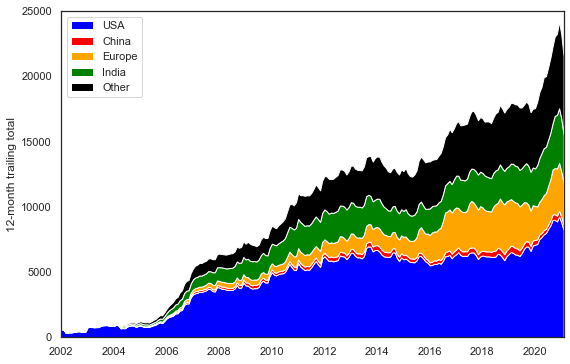

In [1156]:
plt.figure(figsize=(9,6))
plt.stackplot(country_df['year_month'], \
              country_df[['USA', 'China', 'India', 'Europe', 'Other']].to_numpy().T, \
             labels=country_df.columns.to_list()[1:-1], \
             colors=['blue', 'red', 'orange', 'green', 'black']);

plt.legend(loc='upper left');
plt.ylabel('12-month trailing total')
plt.xlim([datetime.datetime(2002,1,1), datetime.datetime(2021,2,1)]);
plt.ylim([0, 25000])

# plt.savefig(cwd+'/appendixF_plots/sim_user_by_country.png', dpi=500,bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/sim_user_by_country.eps',bbox_inches='tight')

plt.show()
# new name - simusers_geo_12months

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


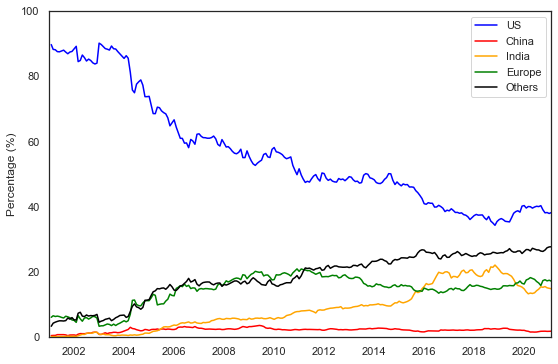

In [1157]:
plt.figure(figsize=(9,6))
plt.plot(country_df['year_month'], \
         country_df['USA'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='US', color='blue');
plt.plot(country_df['year_month'], \
         country_df['China'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='China', color='red');
plt.plot(country_df['year_month'], \
         country_df['India'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='India', color='orange');
plt.plot(country_df['year_month'], \
         country_df['Europe'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='Europe', color='green');
plt.plot(country_df['year_month'], \
         country_df['Other'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='Others', color='black');

plt.xlim([datetime.datetime(2001,1,1), datetime.datetime(2021,2,1)])
plt.ylim([0, 100])
plt.legend(loc='upper right');
plt.ylabel('Percentage (%)')

# plt.savefig(cwd+'/appendixF_plots/sim_user_by_country_perc.png', dpi=500,bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/sim_user_by_country_perc.eps',bbox_inches='tight')

plt.show()
# add '_percent'